In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

In [2]:
import sys; sys.path.append("../offline/")
import sparse, geom, utils

In [6]:
fname = "../data/r%04d_lowq.h5" 

In [312]:
runs = np.arange(82,119)

In [313]:
radial_data, radial_fit = [],[]
diameter, intensity = [],[]
cx,cy, error, runnr = [],[],[],[]
runtag = []
for run in runs:
    with sparse.SmallFrame(fname %run, geometry="../geometry/b3_lowq.geom") as f:
        runnr.append(run*np.ones(f.nframes))
        runtag.append(run + np.linspace(-0.4,0.4,f.nframes))
        radial_data.append(f._handle["radial_data"][:])
        radial_fit.append(f._handle["radial_fit"][:])
        diameter.append(f._handle["diameter"][:])
        intensity.append(f._handle["intensity"][:])
        cx.append(f._handle["cx"][:])
        cy.append(f._handle["cy"][:])
        error.append(f._handle["error_test"][:])
radial_data = np.vstack(radial_data)
radial_fit = np.vstack(radial_fit)
diameter = np.hstack(diameter) * 1e9
intensity = np.hstack(intensity) / (1e-3 / 1e-12)
cx = np.hstack(cx)
cy = np.hstack(cy)
error = np.hstack(error)
runnr = np.hstack(runnr)
runtag = np.hstack(runtag)

In [314]:
valid = (error >= 1) & (diameter > 65)

In [315]:
peak_mean1, peak_std1 = [],[]
peak_mean2, peak_std2 = [],[]
intensity_hist = []
for run in runs:
    r = (runnr[valid] == run)
    I = intensity[valid][r]
    k1 = 0.05*I.shape[0]
    k2 = 0.7*I.shape[0]
    peak_mean1.append(np.sort(I)[-int(k1):].mean())
    peak_std1.append(np.sort(I)[-int(k1):].std())
    peak_mean2.append(np.sort(I)[:int(k2)].mean())
    peak_std2.append(np.sort(I)[:int(k2)].std())
    H,b = np.histogram(I, range=(0,1),bins=100)
    intensity_hist.append(H)
peak_mean1 = np.hstack(peak_mean1)
peak_std1 = np.hstack(peak_std1)
peak_mean2 = np.hstack(peak_mean2)
peak_std2 = np.hstack(peak_std2)
intensity_hist = np.vstack(intensity_hist)

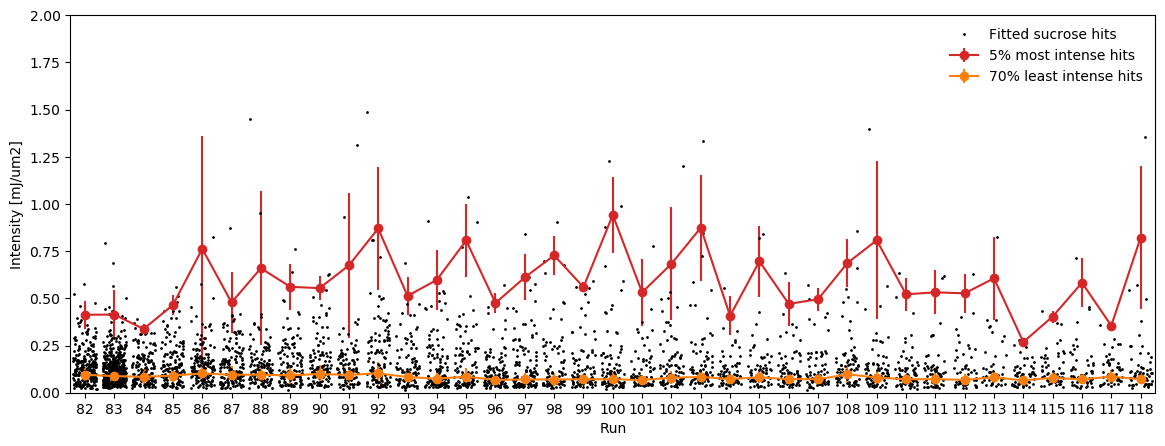

In [316]:
plt.figure(figsize=(14,5), dpi=100)
plt.errorbar(runs, peak_mean1, peak_std1, marker='o', color='tab:red', label='5% most intense hits')
plt.errorbar(runs, peak_mean2, peak_std2, marker='o', color='tab:orange', label='70% least intense hits')
plt.plot(runtag[valid], intensity[valid], 'k.', ms=2, label="Fitted sucrose hits")
plt.ylabel("Intensity [mJ/um2]")
plt.xticks(runs)
plt.xlabel("Run")
plt.legend(frameon=0)
plt.ylim(0,2)
plt.xlim(runs[0]-0.5, runs[-1]+0.5)
plt.show()

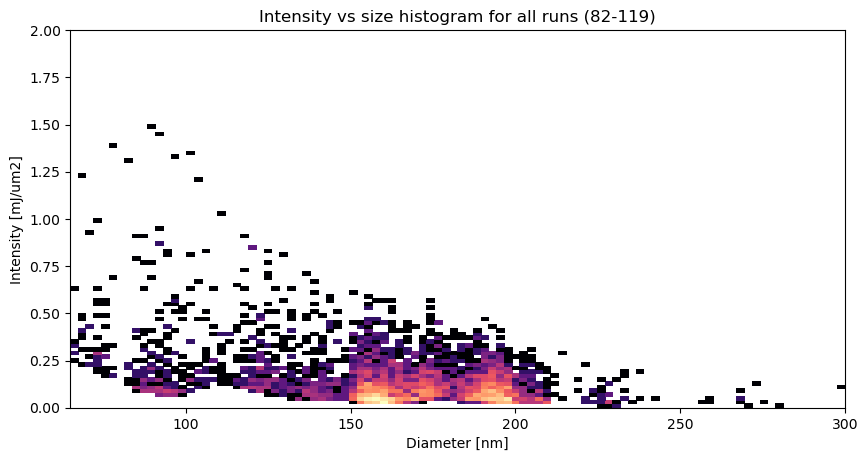

In [317]:
plt.figure(figsize=(10,5), dpi=100)
plt.title("Intensity vs size histogram for all runs (82-119)")
plt.hist2d(diameter[valid], intensity[valid], range=((65,300),(0,2)), bins=100, norm=colors.LogNorm(), cmap='magma')
plt.xlabel("Diameter [nm]")
plt.ylabel("Intensity [mJ/um2]")
plt.xlim(65,300)
plt.show()

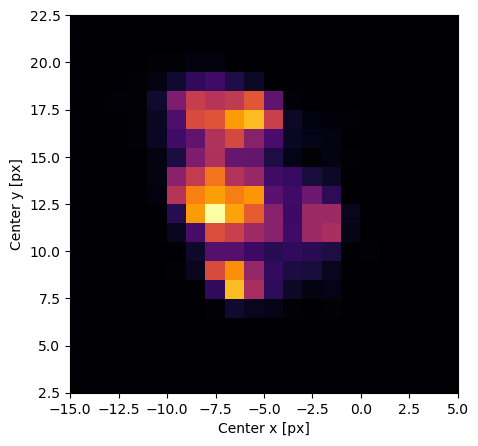

In [318]:
plt.figure(figsize=(5,5), dpi=100)
plt.hist2d(cx[valid],cy[valid], range=((-15,5),(2.5,22.5)), bins=20, cmap='inferno')
plt.xlabel("Center x [px]")
plt.ylabel("Center y [px]")
plt.show()

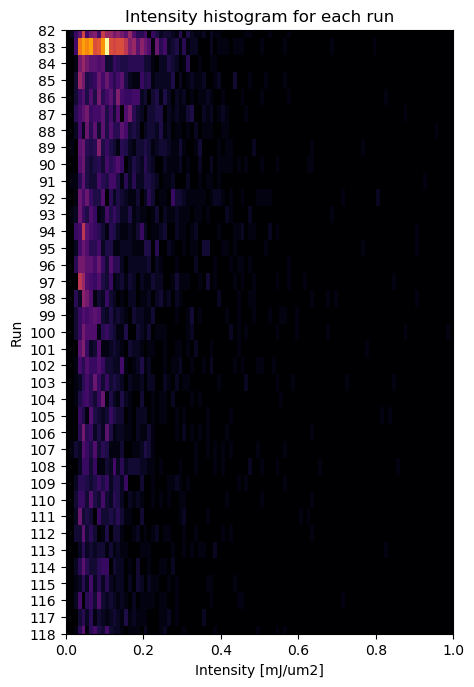

In [319]:
plt.figure(figsize=(5,8), dpi=100)
plt.title("Intensity histogram for each run")
plt.imshow(intensity_hist, aspect='auto', cmap='inferno', 
           extent=[0,1, runs[-1]+1, runs[0]])
plt.yticks(runs+0.5, runs)
plt.ylabel("Run")
plt.xlabel("Intensity [mJ/um2]")
plt.show()